In [15]:
import os
import json
import numpy as np
import heapq
from matplotlib import colors
import matplotlib.pyplot as plt
import torch
import networkx as nx
from networkx.readwrite import json_graph
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
import json
import numpy as np
import heapq
from matplotlib import colors
import matplotlib.pyplot as plt
import torch
import networkx as nx
from networkx.readwrite import json_graph
from graph_to_prompt import graph_to_prompt
import heapq
import networkx as nx
import re


In [ ]:
class DummyLLM:
    def generate_waypoints(self, graph, start, goal, obstacles):
        
        return [start, goal]

def manhattan(u, v):
    return abs(u[0]-v[0]) + abs(u[1]-v[1])


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/opt/conda/envs/LLM/lib/python3.13/site-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [ ]:
# LLM A* 시연
with open("graphs/sejong_bus.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
nodes = G.nodes
edges = G.edges
stations = list(G.nodes())
heuristic_table = {station: np.random.randint(0, 10) for station in stations}

start, goal = 6802360, 6806306
n_points = 2

prompt = graph_to_prompt(G, start, goal, n_points)
inputs = tokenizer_Llama_32_3B(
    prompt,
    return_tensors="pt",
    return_attention_mask=True
)
input_ids = inputs["input_ids"]
# 만약 pad_token_id가 없으면, eos_token_id를 패드로 지정
inputs["input_ids"] = inputs["input_ids"].to(model_Llama_32_3B.device)
inputs["attention_mask"] = inputs["attention_mask"].to(model_Llama_32_3B.device)
model_Llama_32_3B.config.pad_token_id = model_Llama_32_3B.config.eos_token_id

outputs = model_Llama_32_3B.generate(
    **inputs
)

generated_token = outputs[:, input_ids.shape[-1] :]
result = tokenizer_Llama_32_3B.batch_decode(generated_token, skip_special_tokens=True)
print(result)

# 4) 플래너 초기화
planner = GraphLLMAStar(
    graph=G,
    llm=,
    heuristic=lambda n: manhattan(n, goal=(9,9))
)

# 5) 경로 탐색
path = planner.search(start=(0,0), goal=(9,9), obstacles=set())
print(path)

start, goal = 6802360, 6806306  
llm_nodes = [6806306]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)

In [ ]:
import heapq
import networkx as nx

def llm_astar(G, start, goal, heuristic, llm, obstacles=None):

    if obstacles is None:
        obstacles = set()
    else:
        obstacles = set(obstacles)


    T = llm

    if not T or T[0] != start:
        T.insert(0, start)
    if T[-1] != goal:
        T.append(goal)

    T = [t for t in T if t not in obstacles]


    t_idx = 1 if len(T) > 1 else 0
    t = T[t_idx]


    dist_to_t = nx.single_source_dijkstra_path_length(G, t, weight='weight')

    count = 0
    checking_edges = set()
    came_from = {}
    visited = set()

    g_score = {n: float('inf') for n in G.nodes}
    g_score[start] = 0

    f_score = {n: float('inf') for n in G.nodes}
    f_score[start] = g_score[start] + heuristic[start] + dist_to_t.get(start, float('inf'))

    open_set = []
    heapq.heappush(open_set, (f_score[start], g_score[start], start))


    while open_set:
        f_cur, g_cur, current = heapq.heappop(open_set)


        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], g_cur, count, list(checking_edges)

        visited.add(current)


        if current == t and t_idx < len(T) - 1:
            t_idx += 1
            t = T[t_idx]
            dist_to_t = nx.single_source_dijkstra_path_length(G, t, weight='weight')

            new_open = []
            for _, g_old, node in open_set:
                new_f = g_score[node] + heuristic[node] + dist_to_t.get(node, float('inf'))
                new_open.append((new_f, g_old, node))
            open_set = new_open
            heapq.heapify(open_set)


        for nbr in G.successors(current):
            count += 1
            if nbr in visited or nbr in obstacles:
                continue
            w = G[current][nbr].get('weight', 1)
            tentative_g = g_score[current] + w
            checking_edges.add((current, nbr))

            if tentative_g < g_score[nbr]:
                came_from[nbr] = current
                g_score[nbr] = tentative_g
                f = tentative_g + heuristic[nbr] + dist_to_t.get(nbr, float('inf'))
                f_score[nbr] = f
                heapq.heappush(open_set, (f, tentative_g, nbr))


    return None, None, count, list(checking_edges)


In [6]:
with open("graphs/sejong_bus.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
nodes = G.nodes
edges = G.edges
stations = list(G.nodes())
heuristic_table = {station: np.random.randint(0, 10) for station in stations}

/opt/conda/envs/LLM/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [ ]:
start, goal = 6802360, 6806306
n_points = 5

prompt = graph_to_prompt(j, start, goal, n_points)
inputs = tokenizer_Llama_32_3B(
    prompt,
    return_tensors="pt",
    return_attention_mask=True
)
input_ids = inputs["input_ids"]

inputs["input_ids"] = inputs["input_ids"].to(model_Llama_32_3B.device)
inputs["attention_mask"] = inputs["attention_mask"].to(model_Llama_32_3B.device)
model_Llama_32_3B.config.pad_token_id = model_Llama_32_3B.config.eos_token_id
outputs = model_Llama_32_3B.generate(
    **inputs,
    max_new_tokens = 200
)

generated_token = outputs[:, input_ids.shape[-1] :]
result = tokenizer_Llama_32_3B.batch_decode(generated_token, skip_special_tokens=True)
nums_str = re.findall(r'\d+', result[0])  
nums = list(map(int, nums_str))
nums


/opt/conda/envs/LLM/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[6802360, 6802359, 6802358, 6802357, 6802356]

Count       : 641
Cost        : 21
# of Checking edges: 318
Path        : [6802360, 6802357, 6802355, 6805507, 6800758, 6802367, 6801057, 6801062, 6801068, 6801069, 6801070, 6801071, 6801149, 6805706, 6801172, 6806306]


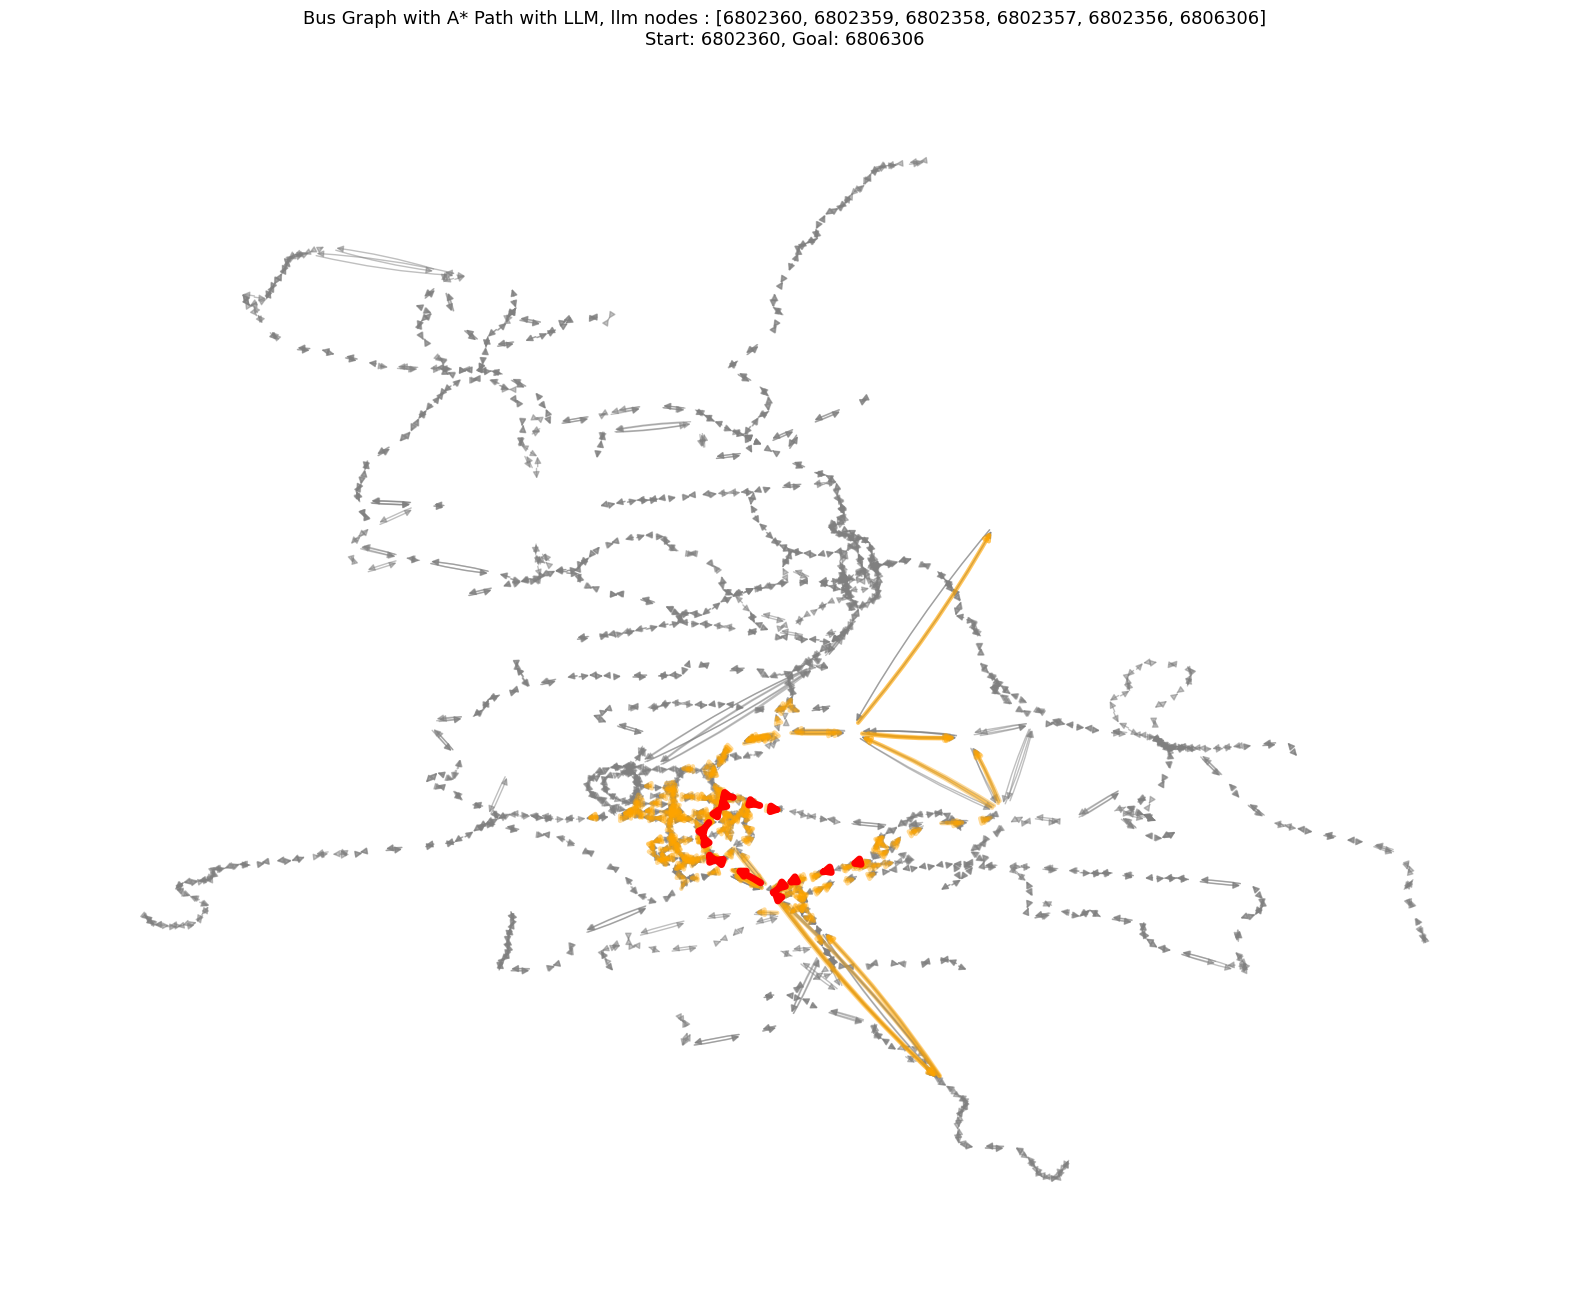

In [24]:
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, nums)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {nums}"
)

In [22]:
def astar(G, start, goal, heuristic):
    count = 0
    checking_edges = set()

    open_set = []
    heapq.heappush(open_set, (heuristic[start], 0, start))

    came_from = {}
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic[start]

    visited = set()

    while open_set:
        _, current_g, current = heapq.heappop(open_set)

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], current_g, count, list(checking_edges)

        visited.add(current)

        for neighbor in G.successors(current):
            count = count + 1
            if neighbor in visited:
                continue

            tentative_g = g_score[current] + G[current][neighbor]['weight']
            checking_edges.add((current, neighbor))
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return None, None, count, list(checking_edges)


def plot_bus_graph(G, path=None, start=None, goal=None,
                   checking_edges=None, weight_tag=True,
                   route_tag=False, node_size=50,
                   title="Bus Routes Graph"):
    """
    - path: A* 결과 (정류장ID list)
    - start, goal: 노드(정류장ID)
    - checking_edges: 탐색 중 확인한 엣지
    - weight_tag: True면 edge weight 표시
    - route_tag: True면 edge에 노선명(route_name) 표시
    - node_size: 노드 크기 
    """
    os_path = "figures/"

    # (1) 노드 위치를 (x, y) 좌표로 지정
    pos = {}
    for n in G.nodes():
        x_coord = G.nodes[n].get('x', 0.0)
        y_coord = G.nodes[n].get('y', 0.0)
        pos[n] = (x_coord, y_coord)

    # (2) 그림 크기, 축 등
    plt.figure(figsize=(20, 16))

    # (3) 전체 엣지
    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        alpha=0.5,
        arrows=True,
        connectionstyle='arc3,rad=0.05'
    )

    # (4) path 강조
    if path:
        path_edges = list(zip(path, path[1:]))

        # 탐색 중 확인한 엣지 (주황색)
        if checking_edges:
            nx.draw_networkx_edges(
                G, pos,
                edgelist=checking_edges,
                edge_color='orange',
                alpha=0.4,
                width=3,
                arrows=True,
                connectionstyle='arc3,rad=0.05'
            )
        # 최종 경로 (빨간색)
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            edge_color='red',
            width=5,
            arrows=True,
            connectionstyle='arc3,rad=0.05'
        )

    # (5) 노드 표시
    else:
        labels = {node: str(node) for node in G.nodes()}
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_size,
            node_color='lightblue'
        )

    # (6) 엣지 라벨
    if weight_tag:
        edge_labels = {
            (u, v): G[u][v].get('weight', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='green'
        )
    elif route_tag:
        edge_labels = {
            (u, v): G[u][v].get('route_name', '')
            for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='blue'
        )


    if path and start and goal:
        title = f"{title}\nStart: {start}, Goal: {goal}"

    plt.title(title, fontsize=13)
    plt.axis('off')
    #plt.tight_layout()
    plt.savefig(os_path + title + '.png' , dpi=200)
    plt.show()

In [7]:
with open("graphs/sejong_bus.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
nodes = G.nodes
edges = G.edges
stations = list(G.nodes())
heuristic_table = {station: np.random.randint(0, 10) for station in stations}

/opt/conda/envs/LLM/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


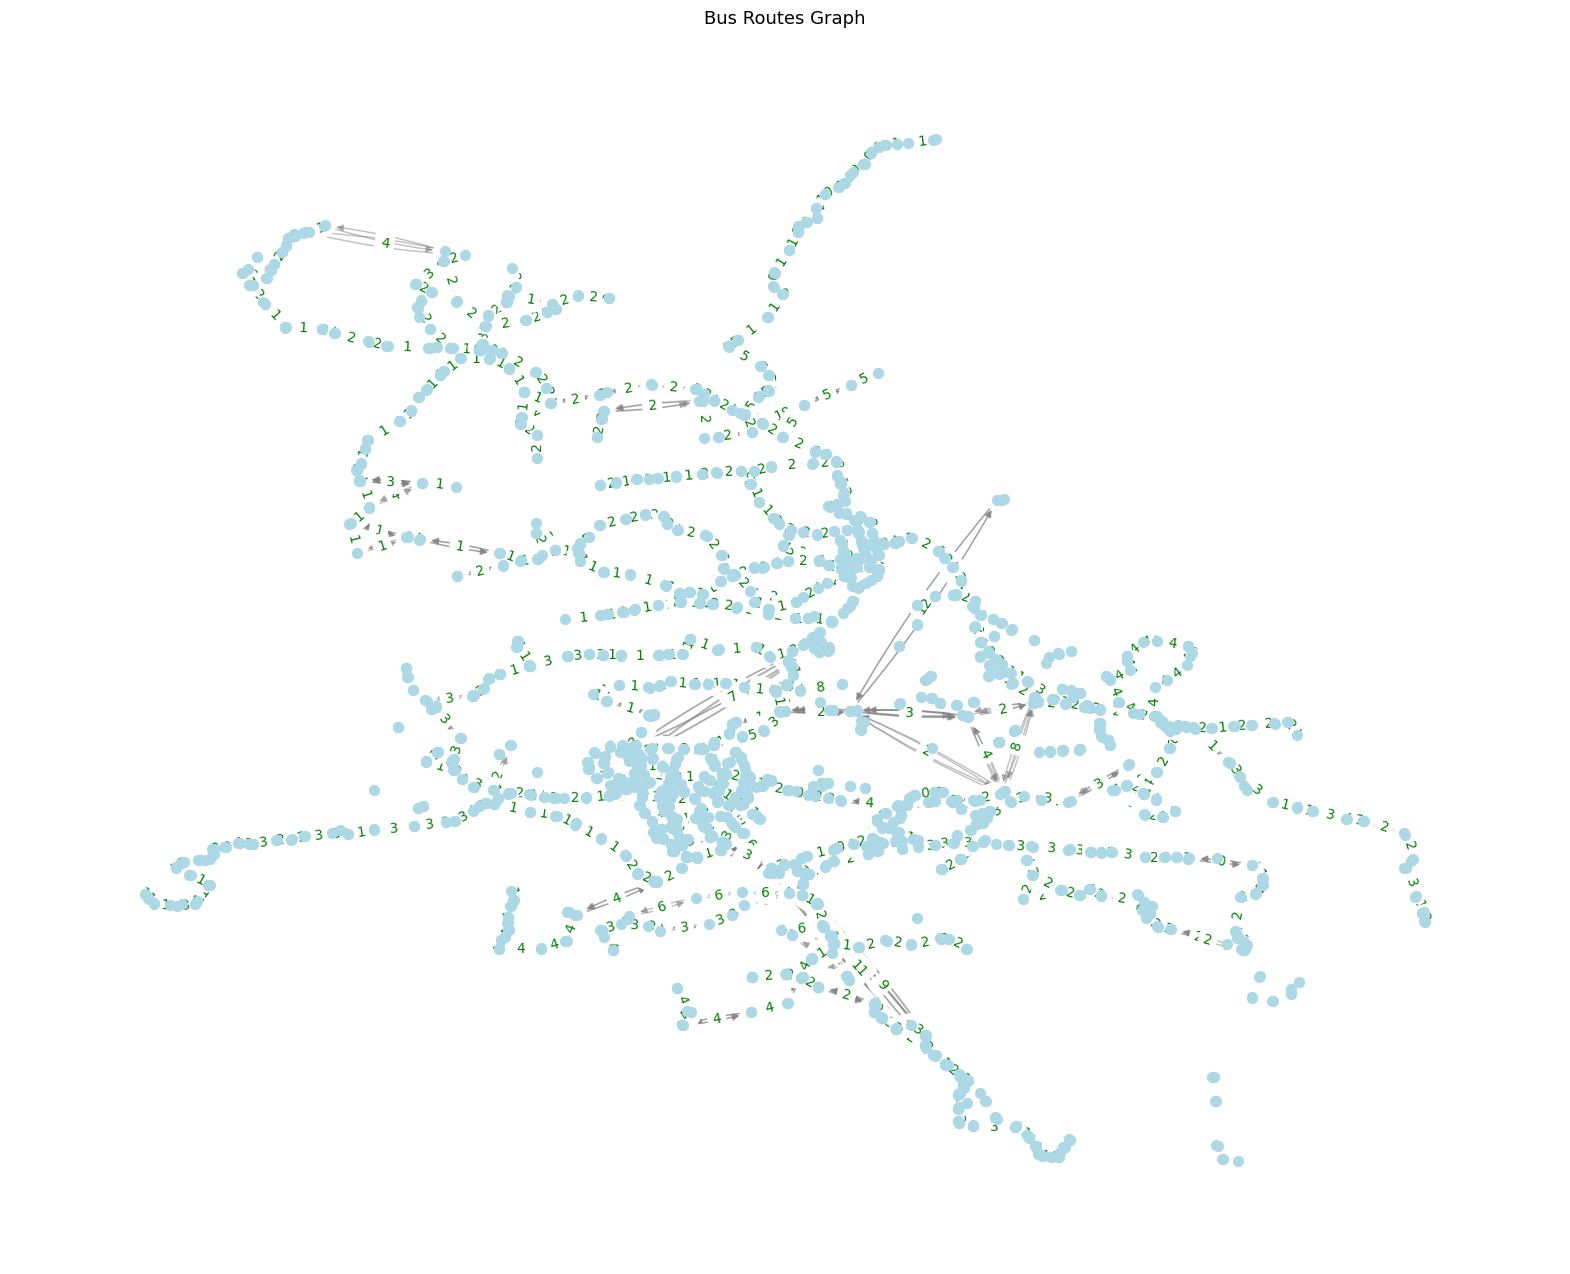

In [9]:
plot_bus_graph(G)

In [41]:
pos

[(36.514017, 127.259393),
 (36.5205, 127.259685),
 (36.52854, 127.263968),
 (36.533838, 127.276657),
 (36.53394, 127.293675),
 (36.53253, 127.31883),
 (36.537768, 127.336985),
 (36.53703, 127.34345),
 (36.53905, 127.34013),
 (36.5457, 127.33441),
 (36.5494, 127.33021),
 (36.55269, 127.32796),
 (36.555077, 127.326537),
 (36.55751, 127.3252),
 (36.561795, 127.322987)]

In [9]:
pos = []
for n in path:
    pos.append((G.nodes[n]['y'],G.nodes[n]['x']))
    print((G.nodes[n]['y'],G.nodes[n]['x']))

(36.514017, 127.259393)
(36.5205, 127.259685)
(36.52854, 127.263968)
(36.533838, 127.276657)
(36.53394, 127.293675)
(36.53253, 127.31883)
(36.537768, 127.336985)
(36.53703, 127.34345)
(36.53905, 127.34013)
(36.5457, 127.33441)
(36.5494, 127.33021)
(36.55269, 127.32796)
(36.555077, 127.326537)
(36.55751, 127.3252)
(36.561795, 127.322987)


In [10]:
import folium
start = stations[30]            
goal = stations[100]           
path, cost, count, checking_edges = astar(G, start, goal, heuristic_table)
m = folium.Map(location=[36.53253, 127.31883], zoom_start=13, width=800, height=500)
folium.PolyLine(pos, color="red", weight=5, opacity=0.8).add_to(m)
folium.CircleMarker([G.nodes[start]['y'],G.nodes[start]['x']], color='#eb9e34').add_to(m)
for n in path:
    folium.Circle([G.nodes[n]['y'], G.nodes[n]['x']], popup='Circle',).add_to(m)
m.save("map.html")

In [11]:
for i, n in enumerate(stations):
    print(stations[n])

IndexError: list index out of range

In [12]:
for i, n in enumerate(stations):
    if G.nodes[stations[i]]['station_name']=='세종호수공원':
        print(G.nodes[stations[i]], i)

{'station_name': '세종호수공원', 'x': 127.27738, 'y': 36.50216} 1117
{'station_name': '세종호수공원', 'x': 127.27744, 'y': 36.50234} 1141
{'station_name': '세종호수공원', 'x': 127.279133, 'y': 36.501882} 1780
{'station_name': '세종호수공원', 'x': 127.277172, 'y': 36.502218} 1971


In [13]:
max_
ind

NameError: name 'max_' is not defined

In [14]:
max_ = 0
ind = None
for i, n in enumerate(stations):
    start = stations[1588]            
    goal = stations[i]           
    path, cost, count, checking_edges = astar(G, start, goal, heuristic_table)
    if path is not None:
        if max_ < cost:
            ind = i
            max_ = cost

16
Count       : 1013
Cost        : 22
# of Checking edges: 473
Path        : [6802360, 6802357, 6802355, 6805507, 6800758, 6802367, 6801057, 6801056, 6801055, 6800055, 6801070, 6801071, 6801149, 6805706, 6801172, 6806306]


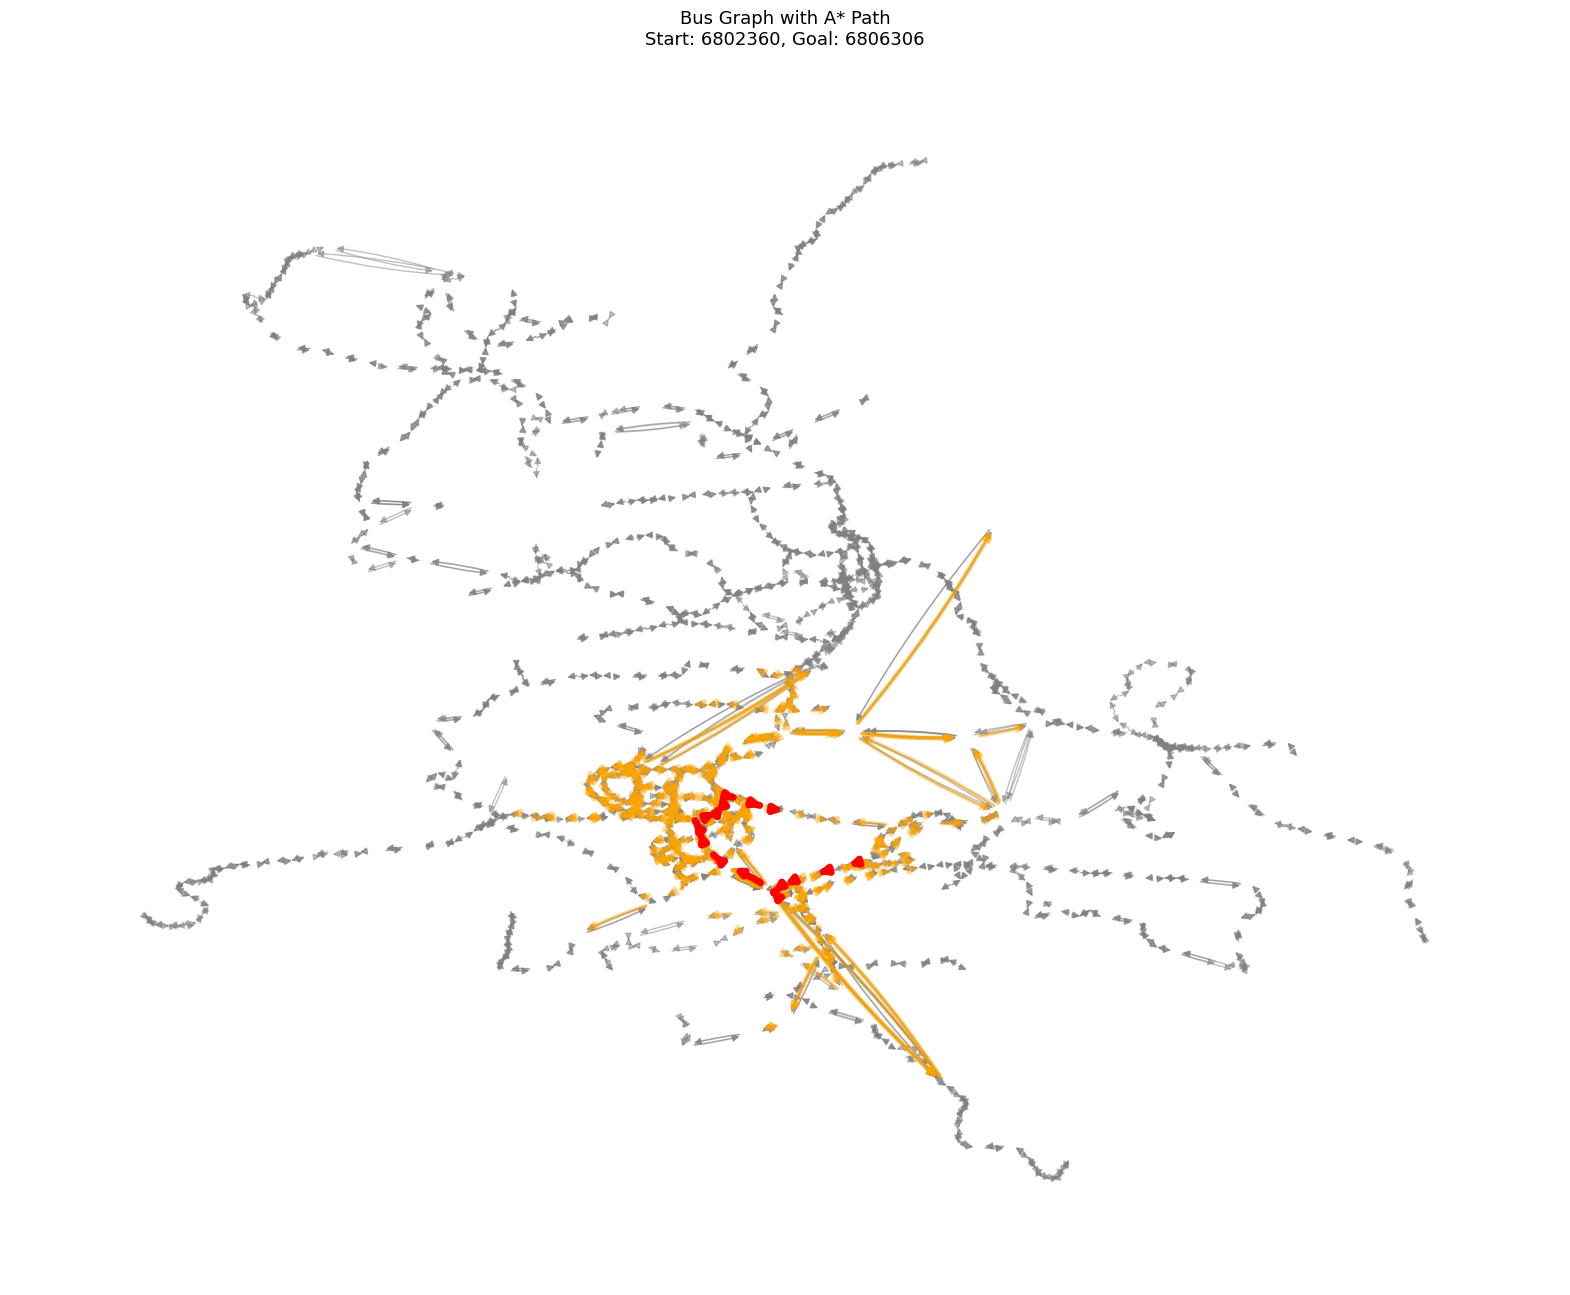

In [16]:
# A* 시연
start, goal = 6802360, 6806306  
path, cost, count, checking_edges = astar(G, start, goal, heuristic_table)
print(len(path)) if path is not None else print("None")

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title="Bus Graph with A* Path"
)

Count       : 1013
Cost        : 22
# of Checking edges: 473
Path        : [6802360, 6802357, 6802355, 6805507, 6800758, 6802367, 6801057, 6801056, 6801055, 6800055, 6801070, 6801071, 6801149, 6805706, 6801172]


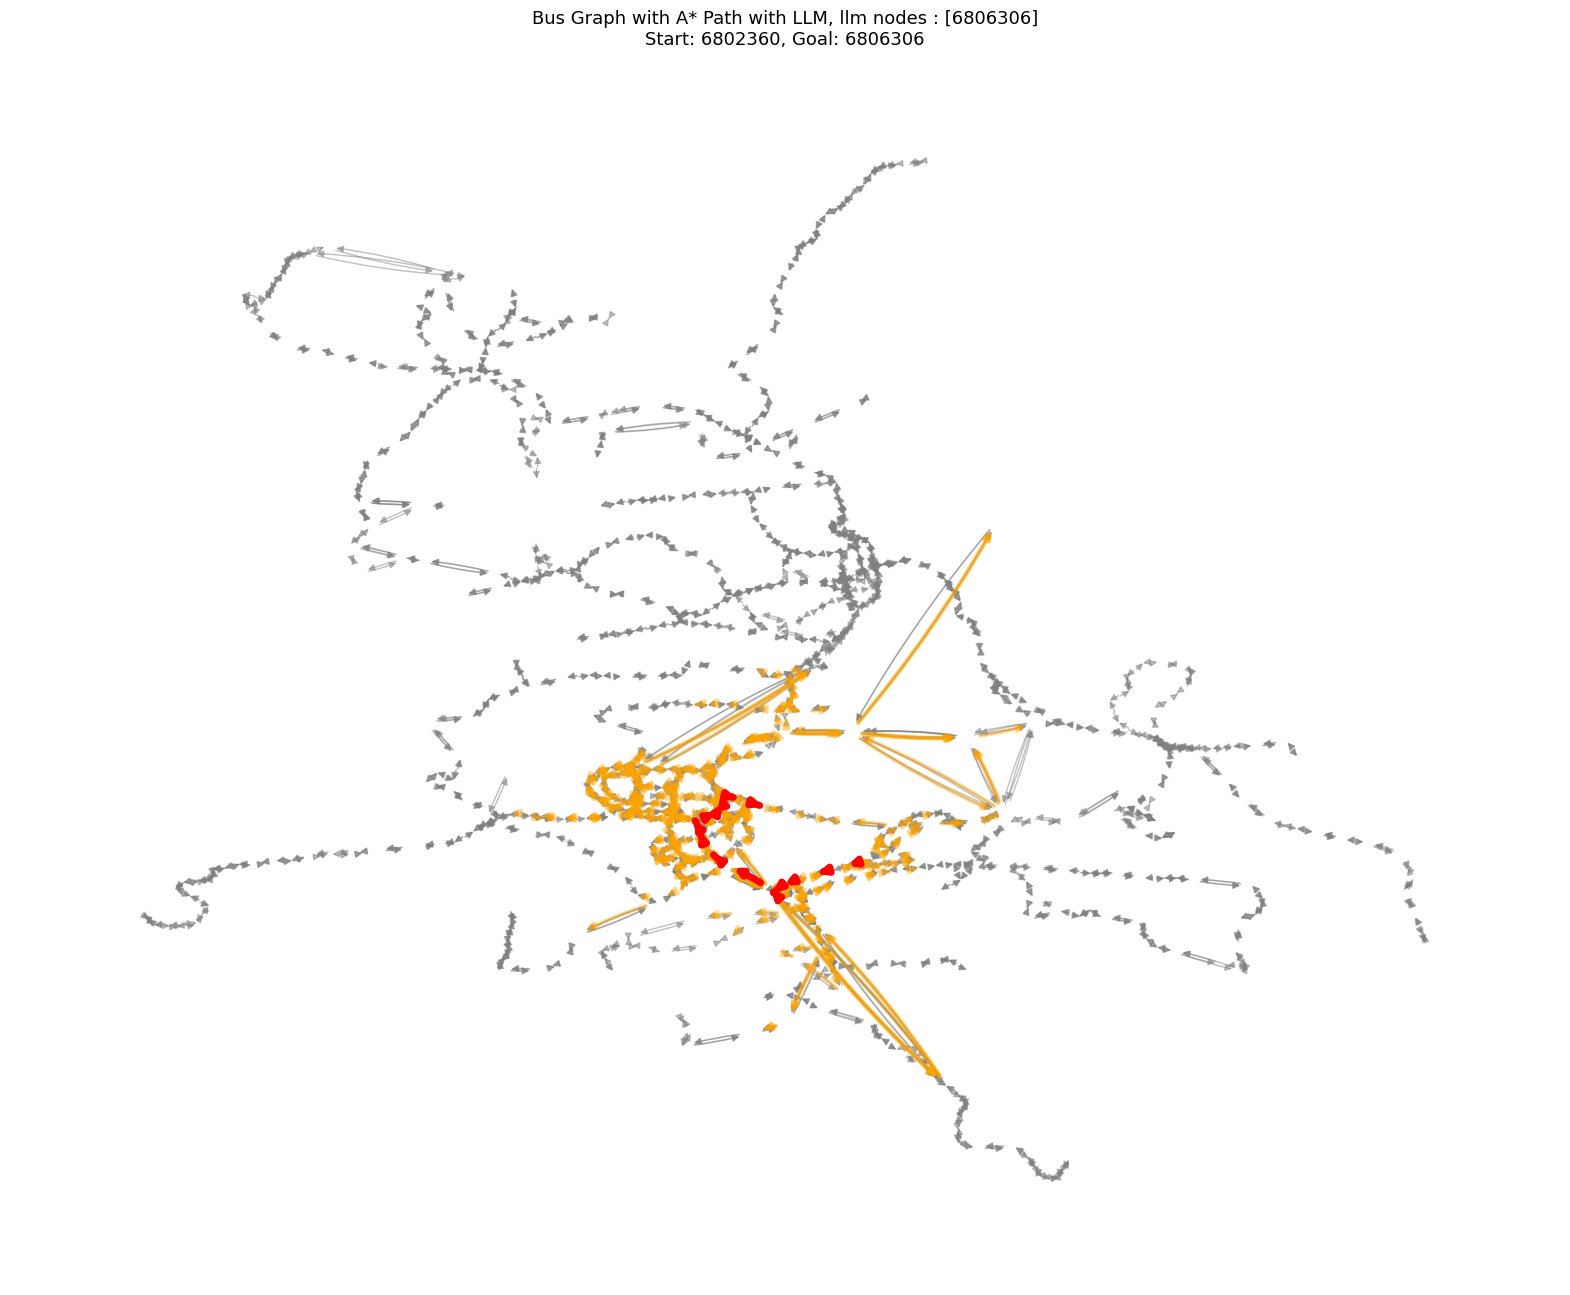

In [18]:
# LLM A* 시연
start, goal = 6802360, 6806306  
llm_nodes = [6806306]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)

Count       : 1180
Cost        : 38
# of Checking edges: 483
Path        : [6802360, 6802357, 6802355, 6805507, 6800758, 6802367, 6801057, 6801289, 6801051, 6805665, 6802353, 6801844, 6802310, 6802361, 6802359, 6801162, 6801842, 6806304, 6806305, 6806306]


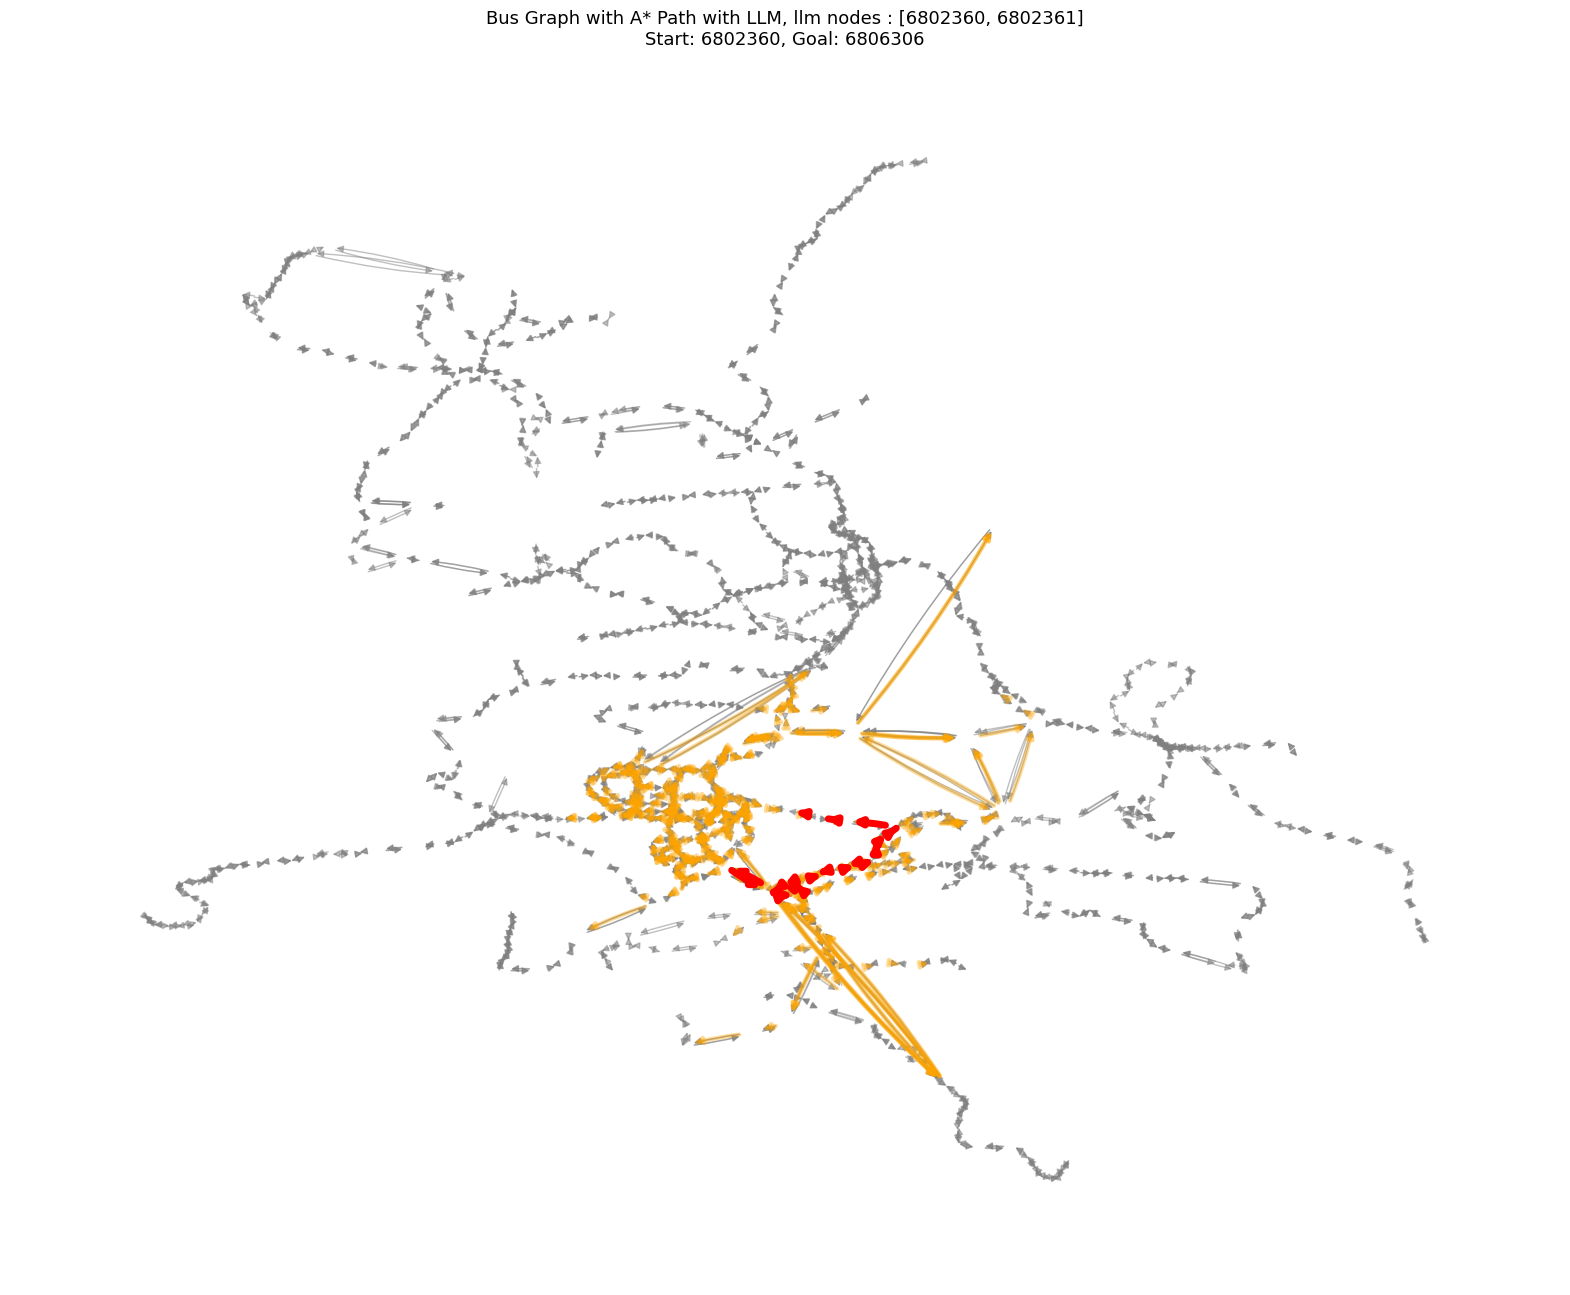

In [19]:
# LLM A* 시연
start, goal = 6802360, 6806306  
llm_nodes = [6802360, 6802361]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)

Count       : 5223
Cost        : 58
# of Checking edges: 1695
Path        : [6800031, 6801875, 6801149, 6805706, 6801172, 6806306, 6806305, 6806304, 6801842, 6801162, 6802359, 6802361, 6802310, 6801844, 6802353, 6802396, 6801289, 6801057, 6801056, 6801055, 6801054, 6801053, 6801174, 6801874, 6800016, 6801817, 6801866, 6801151, 6801152, 6800315, 6800109]


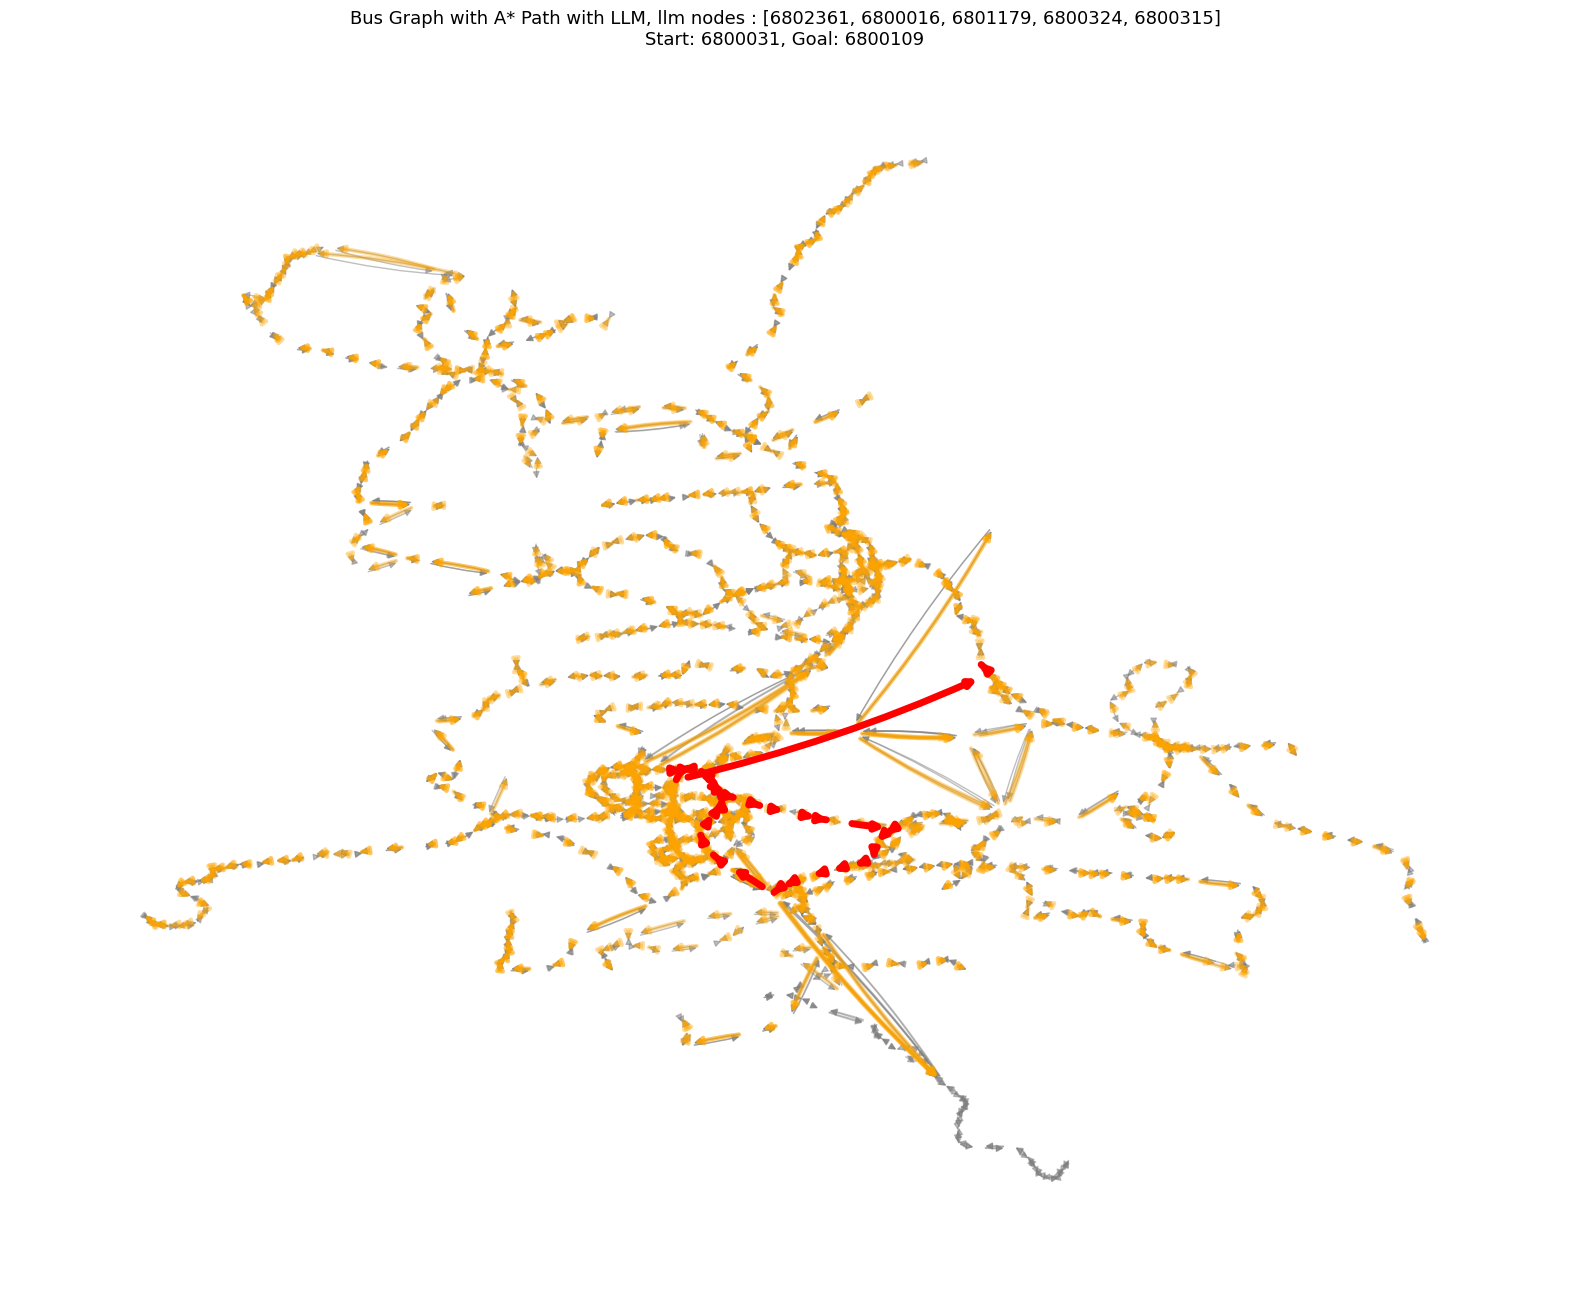

In [8]:
# LLM A* 시연
start = stations[30]            
goal = stations[100]  
llm_nodes = [6802361, 6800016, 6801179, 6800324, 6800315]
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)

print("Count       :", count)
print("Cost        :", cost)
print("# of Checking edges:", len(checking_edges))
print("Path        :", path)
plot_bus_graph(
    G,
    path=path,
    start=start,
    goal=goal,
    checking_edges=checking_edges,
    weight_tag=False,  
    route_tag=False,   
    title=f"Bus Graph with A* Path with LLM, llm nodes : {llm_nodes}"
)